In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import squidpy as sq
import space as sp
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as clr

from matplotlib.colors import LinearSegmentedColormap
from matplotlib import cm
from matplotlib import colors
from termcolor import colored

In [2]:
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity
import scipy.stats as stats

In [3]:
plt.rcParams['axes.unicode_minus']=False
plt.rc('font', family='Helvetica')
plt.rcParams['pdf.fonttype'] = 42
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.set_figure_params(dpi=120,facecolor='w',frameon=True,figsize=(4,4)) 
%config InlineBackend.figure_format='retina'
%matplotlib inline

2023-12-19 14:30:50.021732: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-19 14:30:50.080388: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-19 14:30:50.943467: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


scanpy==1.9.3 anndata==0.9.2 umap==0.5.5 numpy==1.23.5 scipy==1.8.1 pandas==1.5.0 scikit-learn==0.24.2 statsmodels==0.14.0 python-igraph==0.10.4 louvain==0.8.0 pynndescent==0.5.2


In [4]:
featurePlotCols=["lightgrey","whitesmoke","#ffffcc","#ffeda0","#fed976","#feb24c","#fd8d3c","#fc4e2a","#e31a1c","#bd0026","#800026","#800026"]
mymap2 = colors.LinearSegmentedColormap.from_list('my_colormap',featurePlotCols,N=512)

In [5]:
sp.__version__

'0.6.7'

# SES index

In [6]:
adata=sc.read('/data1/liyuzhe/data/SPACE_revision/slice153-1_cc_adata.h5ad')
adata

AnnData object with n_obs × n_vars = 7409 × 254
    obs: 'fovID', 'fov_x', 'fov_y', 'volume', 'center_x', 'center_y', 'slice_id', 'sample_id', 'BICCN_cluster_label', 'BICCN_subclass_label', 'BICCN_class_label', 'BICCN_ontology_term_id', 'assay_ontology_term_id', 'disease_ontology_term_id', 'tissue_ontology_term_id', 'cell_type_ontology_term_id', 'ethnicity_ontology_term_id', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'ethnicity', 'development_stage', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'mouse', 'slice', 'dataset', 'sample', 'subclass', 'subclass_preprocessed', 'leiden_SPACE', 'louvain_SPACE', 'leiden_c8', 'leiden_c5', 'leiden_c0', 'leiden_c0-10-15', 'leiden_c7', 'leiden_c4', 'leiden_c1', 'leiden_c15', 'leiden_c27', 'leiden_c15-27', 'leiden_c23', 'leiden_inh', 'leiden_c0-2', 'celltype_SPACE', 'Cell_Communities_test', 'Cell_

In [7]:
sq.gr.spatial_neighbors(adata, n_neighs=20,coord_type="generic")
adj=adata.obsp['spatial_connectivities'].toarray()
df=pd.DataFrame(index=adata.obs.index,columns=adata.obs.subclass_preprocessed.cat.categories)
for i in range(len(adj)):
    tmp=adata[adj[i].nonzero()]
    df_tmp=tmp.obs.subclass_preprocessed.value_counts(normalize=False)
    df.iloc[i][df_tmp.index]=df_tmp
df=df.fillna(0)
df_sum=df.sum(axis=1)
df=df.div(df_sum,axis=0)

Creating graph using `generic` coordinates and `None` transform and `1` libraries.
Adding `adata.obsp['spatial_connectivities']`
       `adata.obsp['spatial_distances']`
       `adata.uns['spatial_neighbors']`
Finish (0:00:00)


# Cosine similarity

In [8]:
meta=adata.obs.copy()

In [9]:
meta.Cell_Communities=meta.cell_comm.astype('category')

In [10]:
df_cor=pd.DataFrame(cosine_similarity(df),index=df.index,columns=df.index)

In [11]:
df1=pd.DataFrame(index=df_cor.index,columns=['corr','group1','group2']) # celltype:0 ; community:0
df2=pd.DataFrame(index=df_cor.index,columns=['corr','group1','group2']) # celltype:0 ; community:1
df3=pd.DataFrame(index=df_cor.index,columns=['corr','group1','group2']) # celltype:1 ; community:0
df4=pd.DataFrame(index=df_cor.index,columns=['corr','group1','group2']) # celltype:1 ; community:1
df1['group1']='g1'
df2['group1']='g2'
df3['group1']='g3'
df4['group1']='g4'
df1['group2']=df1.index.copy()
df2['group2']=df2.index.copy()
df3['group2']=df3.index.copy()
df4['group2']=df4.index.copy()

In [12]:
for i in df.index:
    cell_com=meta.loc[i,'Cell_Communities']
    celltype=meta.loc[i,'subclass_preprocessed']
    idx1=meta[(meta.Cell_Communities!=cell_com)&(meta.subclass_preprocessed!=celltype)].index.copy()
    idx2=meta[(meta.Cell_Communities!=cell_com)&(meta.subclass_preprocessed==celltype)].index.copy()
    idx3=meta[(meta.Cell_Communities==cell_com)&(meta.subclass_preprocessed!=celltype)].index.copy()
    idx4=meta[(meta.Cell_Communities==cell_com)&(meta.subclass_preprocessed==celltype)].index.copy()
    
    if len(idx1)>0:
        df1.loc[i,'corr']=(df_cor.loc[i,idx1].sum())/(len(idx1))
    else:
        break
    
    if len(idx2)>0:
        df2.loc[i,'corr']=(df_cor.loc[i,idx2].sum())/(len(idx2))
    else:
        break
   
    if len(idx3)>0:
        df3.loc[i,'corr']=(df_cor.loc[i,idx3].sum())/(len(idx3))
    else:
        break
   
    if len(idx4)>1:
        df4.loc[i,'corr']=(df_cor.loc[i,idx4].sum()-1)/(len(idx4)-1)
    else:
        df4.loc[i,'corr']=1

In [13]:
df1['cell_com']=meta['Cell_Communities'].copy()
df2['cell_com']=meta['Cell_Communities'].copy()
df3['cell_com']=meta['Cell_Communities'].copy()
df4['cell_com']=meta['Cell_Communities'].copy()
df1['celltype']=meta['subclass_preprocessed'].copy()
df2['celltype']=meta['subclass_preprocessed'].copy()
df3['celltype']=meta['subclass_preprocessed'].copy()
df4['celltype']=meta['subclass_preprocessed'].copy()

In [14]:
df_all=pd.concat([df1,df2,df3,df4])

<AxesSubplot:xlabel='group1', ylabel='corr'>

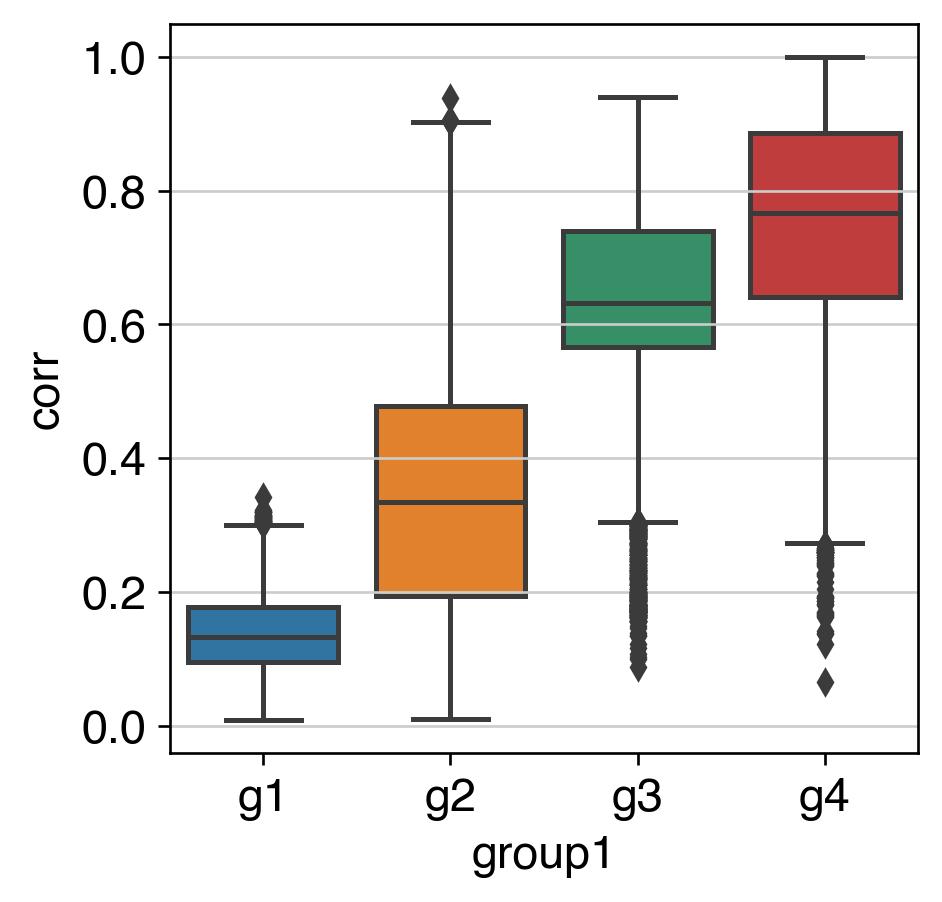

In [15]:
sns.boxplot(data=df_all, x="group1", y="corr")